In [1]:
import torch
import numpy as np
from Packages.RegistrationFunc import *
from Packages.SplitEbinMetric import *
from Packages.GeoPlot import *
import scipy.io as sio
import matplotlib.pyplot as plt
import SimpleITK as sitk

In [2]:
def Vis_quared_distance_Ebin(g0, g1, a=0.5):  
    inv_g0 = get_inverse(g0)
    inv_g0_g1 = torch.einsum("ik...,kj...->...ij",[inv_g0, g1]) # N x N x 2 x 2
    trK0square = trKsquare(g0, g1) - torch.log(get_det(inv_g0_g1) + 1e-25)**2/2 
    theta = torch.min((trK0square/a + 1e-25).sqrt()/4, torch.tensor([np.pi],dtype=torch.double))
    
    det_g0 = g0[0, 0] * g0[1, 1] - g0[0, 1] * g0[1, 0] + 1e-25
    det_g1 = g1[0, 0] * g1[1, 1] - g1[0, 1] * g1[1, 0] + 1e-25
    
    alpha, beta = det_g0.pow(1/4), det_g1.pow(1/4)
    E = 16*a*(alpha**2 - 2*alpha*beta*torch.cos(theta) + beta**2)
    fig = plt.figure()
    im = plt.imshow(E.detach().numpy())
    fig.colorbar(im)
    plt.gca().invert_yaxis()
    plt.show()
    return 0

In [3]:
rect_vary_tens = sitk.GetArrayFromImage(sitk.ReadImage('Data/metpy/metpy_rect_vary_tens.nhdr'))
rect_iso_tens = sitk.GetArrayFromImage(sitk.ReadImage('Data/metpy/metpy_rect_iso_tens.nhdr'))
rect_vary_tens = torch.from_numpy(rect_vary_tens).double()
rect_iso_tens = torch.from_numpy(rect_iso_tens).double()

height, width = rect_vary_tens.shape[:2]
g0, g1 = torch.zeros(2, 2, height, width, dtype=torch.double), torch.zeros(2, 2, height, width, dtype=torch.double)
g0[0, 0] = rect_vary_tens[:,:,0]
g0[0, 1] = rect_vary_tens[:,:,1]
g0[1, 0] = rect_vary_tens[:,:,1]
g0[1, 1] = rect_vary_tens[:,:,2]
g1[0, 0] = rect_iso_tens[:,:,0]
g1[0, 1] = rect_iso_tens[:,:,1]
g1[1, 0] = rect_iso_tens[:,:,1]
g1[1, 1] = rect_iso_tens[:,:,2]

### pointwist Ebin dist between metpy_rect_vary_tens and metpy_rect_iso_tens

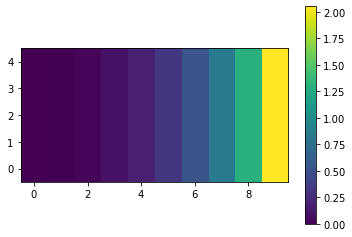

0

In [4]:
Vis_quared_distance_Ebin(g0, g1, a=0.5)

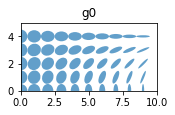

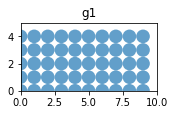

In [5]:
show_2d_tensors(g0, scale=1, title="g0", margin=0.05, dpi=20)
show_2d_tensors(g1, scale=1, title="g1", margin=0.05, dpi=20)

### Karcher Mean of each row in metpy_rect_vary_tens

torch.Size([10, 1, 5, 2, 2])
torch.Size([1, 5, 2, 2])


/home/sci/hdai/MetricMatchZhe/Packages/SplitEbinMetric.py:381: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729006826/work/torch/csrc/utils/python_arg_parser.cpp:882.)
  Ind_inRange = (theta<0).nonzero().reshape(-1) ## G[i] is in the range of the exponential map at gm


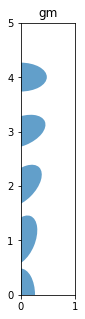

In [6]:
g0_km = torch.unsqueeze(g0,-1).permute(3,4,2,0,1)#[10,1,5,2,2]
print(g0_km.shape)
gm = get_KarcherMean(g0_km, a=0.5)#[1,5,2,2]
print(gm.shape)
show_2d_tensors(gm.permute(2,3,1,0), scale=1, title="gm", margin=0.05, dpi=20)

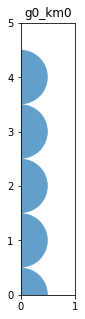

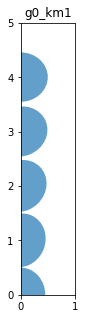

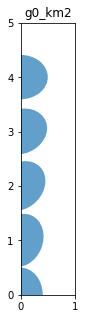

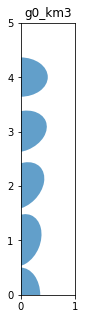

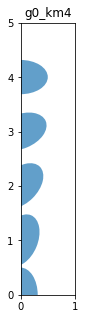

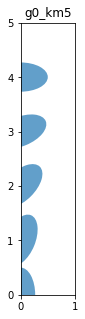

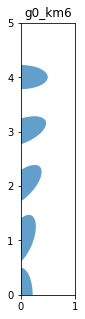

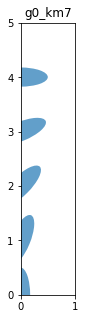

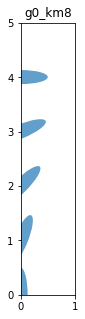

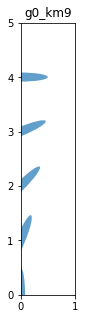

In [7]:
for i in range(10):
    show_2d_tensors(g0_km[i].permute(2,3,1,0), scale=1, title="g0_km"+str(i), margin=0.05, dpi=20)

### Geodesic between the [0,y] and [9,y] in metpy_rect_vary_tens

In [24]:
Tpts = 7
g0_geo = g0.permute(2,3,0,1)
g1_geo = g1.permute(2,3,0,1)
# geo_group = torch.zeros((Tpts,5,10,2,2))
# for i in range(5):
#     geo_group[i] = get_Geo(g0_geo[i,0], g0_geo[i,9], 0.5, Tpts)
geo_group = get_Geo(g0_geo, g1_geo, 0.5, Tpts)

In [25]:
# show_2d_tensors(geo_group[i].permute(2,3,0,1), scale=1, title="gm", margin=0.05, dpi=20)

In [26]:
def show_2d_tensors(nda0, scale=0.5, title=None, margin=0.05, dpi=80):
    
    nda = torch.zeros(*nda0.shape[-2:], 3, dtype=torch.double)
    nda[:,:,0] = nda0[0,0,:,:]
    nda[:,:,1] = nda0[0,1,:,:]
    nda[:,:,2] = nda0[1,1,:,:]
    nda = nda.numpy()
    
    if nda.ndim == 3:
      # fastest dim, either component or x
      c = nda.shape[-1]       
      # the number of component is 3 consider it a tensor image
      if c != 3:
        raise Runtime("Unable to show 3D-vector Image")

    xsize = nda.shape[0]
    ysize = nda.shape[1]

    # Make a figure big enough to accommodate an axis of xpixels by ypixels
    # as well as the ticklabels, etc...
    if xsize > dpi and ysize > dpi:
        figsize = (1 + margin) * ysize / dpi, (1 + margin) * xsize / dpi
    else:
        figsize = (1 + margin) * dpi / ysize, (1 + margin) * dpi / xsize
        
    fig = plt.figure(figsize=figsize)
    # Make the axis the right size...
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    tens = np.zeros((2,2))
    triu_idx = np.triu_indices(2)
    ellipses = []
#     xax = [1,0]
    for x in range(xsize):
        for y in range(ysize):
            tens[triu_idx] = nda[x,y]
            tens[1,0] = tens[0,1]
            evals, evecs = np.linalg.eigh(tens)
            angle = np.degrees(np.math.atan2(evecs[1][0],evecs[1][1]))
            ellipses.append(Ellipse((y,x), width=scale * evals[1], height = scale * evals[0], angle=angle))
    collection = PatchCollection(ellipses, alpha=0.7,color='k')
    ax.add_collection(collection)
    ax.set_xlim(0,ysize)
    ax.set_ylim(0,xsize)
    ax.set_aspect('equal')
    plt.axis('off')
    
#     if(title):
#         plt.title(title)
    plt.savefig(title, bbox_inches='tight')

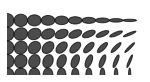

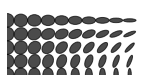

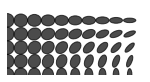

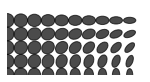

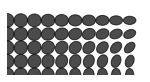

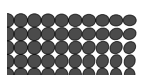

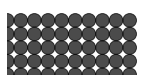

In [27]:
for i in range(Tpts):
    show_2d_tensors(geo_group[i].permute(2,3,0,1), scale=1, title="rect"+str(i)+'.pdf', margin=0.05, dpi=20)